In [1]:
DATA_DIR = '/path_to_data/'
fig_save_path ='/path_to_figures/'

In [2]:
# scanpy packages 
import scanpy as sc
import scanpy.external as sce
import anndata as anndata
#import diffxpy.api as de
from anndata import AnnData

# other packages
import time
import os
import numpy as np
import seaborn as sns
import pandas as pd
import re
import h5py
import scipy

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import matplotlib.colors as colors
import matplotlib.font_manager
%matplotlib inline

# other packages
import glob
from collections import OrderedDict
from scipy.sparse import csr_matrix
#import diffxpy.api as de
from scanpy.external.pp import magic
from scipy.stats import zscore
import scipy.cluster.hierarchy as hc
from statistics import median
import math
from typing import Union

#functions
def randomize_cells(anndata_object):
    "Randomize cells for plotting UMAP"
    index_list = np.arange(anndata_object.shape[0])
    np.random.shuffle(index_list)
    anndata_object = anndata_object[index_list]
    return anndata_object

# to remove nan from dict
def sqlargs(kargs: dict, val: Union[str, int] = "NULL") -> dict:
    """\
    A cleaner for `nan` data types of empty values in dictionary.
    :param kargs:
        Dirty dictionary
    :param val: 
        Replacement value
    :return:
        Clean dictionary
    """
    for k, v in kargs.items():
        if isinstance(v, dict):
            sqlargs(v)
        else:
            kargs[k] = [v for v in kargs[k] if not (isinstance(v, float) and math.isnan(v))]
    return kargs

import numpy.matlib

#from kneed import KneeLocator

In [3]:
from scrnaseq_preprocessing_utils import *
from SPECTRA_processing_utils import *

ModuleNotFoundError: No module named 'rpy2'

In [ ]:
#set style
sns.set_style('white')
# define colors
color_map_clusters = ["#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
"#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
"#5A0007", "#809693", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
"#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
"#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
"#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
"#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
"#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
"#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
"#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
"#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
"#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
"#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C"]

color_map_clusters_nogrey = ["#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
"#5A0007", "#809693", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
"#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
"#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
"#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
"#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
"#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
"#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
"#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
"#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
"#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
"#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C"]

blue_red = ['#0E518F','#DF480F']
expansion_dict = {'NE':'#0E518F','E': '#DF480F','nan':'#000000'}
timepoint_dict = {'Pre': '#0E518F', 'Post': '#DF480F', 'nan': '#000000'}
subtype_color_dict = {'TAM':'#FFFF00','global':'#FFFFFF',
                 'DC_cDC2A':'#1CE6FF',
                 'pDC':'#FF34FF',
                 'M-MDC':'#FF4A46',
                 'mono_c':'#008941',
                 'mast':'#006FA6',
                      'TAM_TRMac':'#456D75',
                 'DC_cDC1':'#A30059',
                 'Gr-MDC':'#7A4900',
                 'DC_Langerhans':'#0000A6',
                      'DC_AXLpos_ITGAXpos':'#0CBD66',
                      'DC_FDC_PTPRCpos':'#EEC3FF',
                'DC_cDC3':'#63FFAC',
                'CD8_T':'#B79762',
                'Treg':'#004D43',
                'CD4_T':'#8FB0FF',
                'CD8_T':'#997D87',
                 'NK':'#5A0007',
                 'gdT':'#809693',
                    'ILC3':'#7900D7',
                       'CD8_T_KLRG1pos_effector_preexhausted':'#4FC601',
                 'CD4_T_naive':'#3B5DFF',
                 'CD4_T_TH1':'#4A3B53',
                 'CD8_T_TRM':'#FF2F80',
                'CD8_T_TRM_exhausted':'#61615A',
                 'CD8_T_naive':'#BA0900',
                 'CD8_T_KLRG1pos_effector_preexhausted':'#6B7900',
             'CD4_T_naive_low_libsize':'#00C2A0',
                 'CD8_T_naive':'#FFAA92',
             'NK_CD56bright':'#FF90C9',
                 'CD8_T_TEM_effector_exhausted-progenitor':'#B903AA',
            'gdT':'#D16100',
              'CD8_T_KLRG1pos_effector_nonexhausted':'#BFC1E3',
              'CD8_T_TRM_exhausted_proliferating':'#000035',
            'CD4_T_TH1_proliferating':'#7B4F4B',
               'NK_CD56dim':'#A1C299',
               'Treg':'#300018',
                  'CD8_T_KLRG1pos_effector_preexhausted':'#0AA6D8',
                         'MDC':'#013349',
                 'DC':'#00846F',
                'mixed_T_M':'#636375',
                        'B_memory':'#372101',
                
                 'B_naive':'#FFB500',
                'plasma':'#C2FFED',
                'B_GC':'#A079BF',
                    'B_memory_switched':'#CC0744',
                'plasma_IgA':'#C0B9B2',
                 'B_memory_double_neg':'#C2FF99',
               'plasma_IgG':'#001E09',
                'plasmablast':'#00489C',
               'plasma_Be1':'#6F0062',
                     'M':'#B77B68',
                     'TNK':'#7A87A1',
                     'B':'#788D66',
                     'TAM_MKlike':'#885578',
                     'mono':'#34362D',
                     'mono_c':'#B4A8BD',
                     'mono_nc':'#00A6AA',
                     'ILC1':'#452C2C',
                     'CD4_T_TFH':'#A3C8C9',
                     'CD4_T_TFH_exhausted-progenitor':'#FF913F',
                     'CD4_T_TSCM':'#938A81',
                     'CD8_T_KLRG1neg_effector_preexhausted':'#575329',
                     'CD8_T_KLRG1pos_effector_exhausted':'#00FECF',
                     'CD8_T_TRM_nonexhausted':'#B05B6F',
                     'CD8_T_innate-like':'#DCD11C',
                     'TNK_proliferating':'#3B9700',
                     'NK_CD56dim_proliferating':'#04F757',
                     'T':'#C8A1A1',
                     'T_proliferating':'#1E6E00',
                     'B_memory':"#BC23FF",
                      'B_naive':"#A77500",
                      'plasma':"#6367A9",
                 'B_GC':"#A05837",
                      'B_memory_switched':"#6B002C",
                 'B_naive':"#772600",
              'plasma_IgA':"#D790FF",
                'B_memory_double_neg':"#9B9700",
               'plasma_IgG':"#549E79",
                 'plasmablast':"#FFF69F",
                'plasma_IgG':"#201625",
                 'plasma_Be1':"#72418F",
                      'B':"#922329", 
                      'TNK':"#99ADC0",
                      'M': "#3A2465",
                      'nan':'#000000',
                      'B_GC_proliferating':'#5B4534',
                      'B_memory_switched_Be1':'#FDE8DC',
                      'B_memory_switched_proliferating':'#404E55',
                      'plasma_IgG_Be1':'#0089A3',
                       'B_proliferating':'#CB7E98'
                }


batlow_20 = ['#1d2356','#1d2b59',
'#14375e',
'#134460',
'#1c5261',
'#235f5f',
'#396a58',
'#4c714e',
'#607843',
'#757e36',
'#8d8532',
'#a78b30',
'#c49138',
'#dc954d',
'#f09c6a',
'#f8a487',
'#f8aca2',
'#f8b5be',
'#f8c2d9',
'#eecbe1'] 
import random
random.seed(1)
random.shuffle(batlow_20)

perturbation_map = ['#EFD060','#0289DE','#0289DE','#DCA6C4']
stage_map = ['#EFD060','#0289DE','#67C6F8','#DCA6C4']
stage_map_2 = ['#EFD060','#0289DE','#DCA6C4']
perturbation_stage_map_2 = ['#F95957', '#FF0300','#EFD060','#0289DE','#0289DE','#DCA6C4','#EFD060','#0289DE','#DCA6C4']
perturbation_stage_map = ['#F95957', '#FF0300','#e1e1e1','#e1e1e1','#e1e1e1','#e1e1e1', '#EFD060','#0289DE','#DCA6C4']
color_map_clusters_plt = cm = LinearSegmentedColormap.from_list(
        'color_map_clusters', color_map_clusters)
treat_untreat_palette = ['#0E518F', '#DF480F', '#a7a7a7']
#scanpy layout
sc.set_figure_params(scanpy=True, dpi=150, dpi_save=300, frameon=False, vector_friendly=True, fontsize=7, figsize=None, color_map=None, format='pdf', facecolor=None, transparent=True, ipython_format='png2x')
sns.set_style('white')

# recalculate embeddings (more PCs to seperate cell types annotated on the subsets)

In [12]:
adata_path_adata = 'TIL-X-BRCA-X-Zhang-X-2021-X-all_cells_raw_annotated_clustered_nodrops_nodoub_tumor_scran_labeled_clustered_annotated_211208_removed-doublets_graph0.01_delta_0.001_beta_0.0_pseudo_0.0.h5ad'
adata_path = DATA_DIR + adata_path_adata
adata_save_path = adata_path[:-5]+'_50PC_reembedded.h5ad'

In [ ]:
#load adata
adata = sc.read(adata_path)
adata

In [ ]:
isinstance(adata.X, scipy.sparse.csr_matrix) !=True

In [ ]:
if isinstance(adata.X, scipy.sparse.csr_matrix) != True:
    adata.X = scipy.sparse.csr_matrix(adata.X)
adata.X

In [ ]:
#select optimal number of PCs and recalculate PCs
number_of_PC_used = calculate_optimal_PC(adata, min_PC = 50, min_var=25, n_comps=100, use_hv=None)

In [ ]:
#recalc umap
sc.pp.neighbors(adata, n_neighbors=10, method= 'umap', n_pcs=number_of_PC_used,random_state=0)
sc.tl.umap(adata,random_state=0)

In [ ]:
#recalc tsne
sc.tl.tsne(adata, random_state = 7, n_pcs=number_of_PC_used)

In [ ]:
#recalc fdl
sc.tl.draw_graph(adata, layout='fa', init_pos=None, root=None, random_state=0, n_jobs=None, adjacency=None, key_added_ext=None, neighbors_key=None, obsp=None, copy=False)

In [ ]:
#recalc DCs
sc.tl.diffmap(adata, n_comps=15, neighbors_key=None, copy=False)

In [ ]:
#recalculate magic
a = magic(adata, copy=True, verbose=True, solver= 'exact', n_pca=adata.obsm['X_pca'].shape[1], knn=5, t=3)
adata.layers['imputed'] = a.X

In [ ]:
#save
adata.write(adata_save_path)
print('saved adata to:',adata_save_path)

In [13]:
adata = sc.read(adata_save_path)

Only considering the two last: ['.0_50PC_reembedded', '.h5ad'].
Only considering the two last: ['.0_50PC_reembedded', '.h5ad'].


# plasma cell validation

In [5]:
adata_path_adata = 'TIL-X-BRCA-X-Zhang-X-2021-X-all_cells_raw_annotated_clustered_nodrops_nodoub_tumor_scran_labeled_clustered_annotated_211208_removed-doublets_naive0.01_delta_0.001_beta_0.0_pseudo_0.0.h5ad'

adata_path = DATA_DIR + adata_path_adata 

In [6]:
#read adata
adata = sc.read(adata_path)
adata

Only considering the two last: ['.0', '.h5ad'].
Only considering the two last: ['.0', '.h5ad'].


AnnData object with n_obs × n_vars = 150985 × 20237
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'patient_id', 'biomaterial', 'timepoint', 'site', 'age', 'PD-L1_IC_Ventana', 'TIL', 'T', 'N', 'M', 'treatment', 'RECIST', 'biopsied_lesion_size', '8w_biopsied_lesion', 'target_lesion_size', '8w_target_lesion', 'PFS', 'last_follow_up', 'pheno_k10', 'pheno_k20', 'pheno_k30', 'pheno_k40', 'pheno_k50', 'pheno_k60', 'pheno_k70', 'pheno_k80', 'pheno_k90', 'pheno_k100', 'annotation_SPADE_1', 'annotation_SPADE_2', '0-X-all_multidrug-resistance', '1-X-all_porphyrine-heme_metabolism', '2-X-all_TNF-via-NFkB_signaling', '3-X-all_glyoxylate-dicarboxylate_metabolism', '4-X-all_IL6-JAK-STAT3_signaling', '5-X-all_fatty-acid-beta-oxidation-peroxisomal', '6-X-all_triacylglycerol_synthesis', '7-X-all_circadian-rhythm', '8-X-8', '9-X-all_au

In [20]:
factor_name_list = ['0-X-all_multidrug-resistance-X-norm', '1-X-all_porphyrine-heme_metabolism-X-norm', '2-X-all_TNF-via-NFkB_signaling-X-norm', '3-X-all_glyoxylate-dicarboxylate_metabolism-X-norm', '4-X-all_IL6-JAK-STAT3_signaling-X-norm', '5-X-all_fatty-acid-beta-oxidation-peroxisomal-X-norm', '6-X-all_triacylglycerol_synthesis-X-norm', '7-X-all_circadian-rhythm-X-norm', '8-X-all_heparan-sulfate_degradation-X-norm', '9-X-all_autophagy-of-mitochondria_regulation_positive-X-norm', '10-X-all_TNF-via-NFkB_signaling-X-norm', '11-X-all_autophagy_regulation_positive-X-norm', '12-X-all_DNA-demethylation-X-norm', '13-X-all_TYR_metabolism-X-norm', '14-X-all_autophagy-of-mitochondria-X-norm', '15-X-15-X-norm', '16-X-all_transmembrane-transport-golgi-X-norm', '17-X-all_osmotic-stress-response-X-norm', '18-X-all_o-glycan_synthesis-X-norm', '19-X-all_transmembrane-transport-mitochondrial-X-norm', '20-X-all_cytosolic-DNA-sensing_signaling-X-norm', '21-X-all_mitophagy-X-norm', '22-X-all_posttranslation-modification-X-norm', '23-X-all_actin-cytoskeleton_regulation-X-norm', '24-X-all_autophagic-cell-death-X-norm', '25-X-all_MHC-I-presentation-X-norm', '26-X-all_histone-methylation-X-norm', '27-X-all_G2M-transition-X-norm', '28-X-all_Beta-Ala_metabolism-X-norm', '29-X-all_Beta-Ala_metabolism-X-norm', '30-X-all_pterin_synthesis-X-norm', '31-X-all_oxidative-phosphorylation-X-norm', '32-X-all_creatinine_metabolism-X-norm', '33-X-all_autophagy_regulation_positive-X-norm', '34-X-all_NAD_metabolism-X-norm', '35-X-all_wnt-beta-catenin-signaling-X-norm', '36-X-36-X-norm', '37-X-all_macroautophagy-X-norm', '38-X-all_CYS_metabolism-X-norm', '39-X-39-X-norm', '40-X-all_ketone-body_metabolism-X-norm', '41-X-all_ROS-detoxification-X-norm', '42-X-all_NOD-like-receptor_signaling-X-norm', '43-X-all_xenobiotics_metabolism-X-norm', '44-X-all_autophagic-cell-death-X-norm', '45-X-all_apoptosis-X-norm', '46-X-all_TCA-cycle-X-norm', '47-X-all_transmembrane-transport-lysosome-X-norm', '48-X-all_bile-acid_synthesis-X-norm', '49-X-all_peroxisome-component-X-norm', '50-X-50-X-norm', '51-X-leuko_ROS_production-X-norm', '52-X-all_n-glycan_synthesis-X-norm', '53-X-53-X-norm', '54-X-all_urea-cycle-X-norm', '55-X-all_type-I-ifn-response-X-norm', '56-X-all_glycogenesis-X-norm', '57-X-all_polyamines_metabolism-X-norm', '58-X-all_fructose-mannose_metabolism-X-norm', '59-X-all_thiamin_metabolism-X-norm', '60-X-60-X-norm', '61-X-all_fatty-acid-metabolism-X-norm', '62-X-all_NOTCH_signaling-X-norm', '63-X-all_purine_metabolism-X-norm', '64-X-all_nucleotide_metabolism-X-norm', '65-X-all_CoA_synthesis-X-norm', '66-X-all_platelet-activation-factor_production-X-norm', '67-X-all_ubiquinone_synthesis-X-norm', '68-X-all_CYP_metabolism-X-norm', '69-X-all_iron-uptake-and-storage-X-norm', '70-X-all_chondroitine-and-heparan-sulfate_synthesis-X-norm', '71-X-all_coagulation-factor_production-X-norm', '72-X-all_VAL-LEU-ILE_metabolism-X-norm', '73-X-all_glycogenolysis-X-norm', '74-X-all_HIS_metabolism-X-norm', '75-X-all_actin-cytoskeleton_regulation-X-norm', '76-X-all_lactate_production-X-norm', '77-X-all_SASP-X-norm', '78-X-all_eicosanoid_metabolism-X-norm', '79-X-all_riboflavin_metabolism-X-norm', '80-X-leuko_ROS_production-X-norm', '81-X-all_GPI-anchor_synthesis-X-norm', '82-X-all_cholesterol_metabolism-X-norm', '83-X-all_inositol-phosphate_metabolism-X-norm', '84-X-all_unfolded-protein-response-X-norm', '85-X-all_protein-degradation-proteasome-X-norm', '86-X-all_retinol_metabolism-X-norm', '87-X-all_cholesterol-homeostasis-X-norm', '88-X-all_sphingolipid_metabolism-X-norm', '89-X-all_transmembrane-transport-cellmembrane-X-norm', '90-X-all_MET_metabolism-X-norm', '91-X-all_pyrimidine_metabolism-X-norm', '92-X-all_TLR_signaling-X-norm', '93-X-all_ascorbate-uptake-X-norm', '94-X-94-X-norm', '95-X-all_TRP_metabolism-X-norm', '96-X-all_oxidative-phosphorylation-X-norm', '97-X-all_ARG-PRO_metabolism-X-norm', '98-X-all_selenoamino-acid_metabolism-X-norm', '99-X-all_galactose_metabolism-X-norm', '100-X-all_JAK-STAT_signaling-X-norm', '101-X-all_DNA_synthesis-X-norm', '102-X-all_G1S-transition-X-norm', '103-X-all_LYS_metabolism-X-norm', '104-X-all_hyaluronan_metabolism-X-norm', '105-X-all_GABA-shunt-X-norm', '106-X-all_propanoate_metabolism-X-norm', '107-X-all_GLU_metabolism-X-norm', '108-X-all_exocytosis-X-norm', '109-X-all_pyrimidine_synthesis-X-norm', '110-X-all_fatty-acid_synthesis-X-norm', '111-X-all_carnitine-shuttle-X-norm', '112-X-all_DNA-repair-X-norm', '113-X-all_biotin_metabolism-X-norm', '114-X-all_cyclic-nucleotide_metabolism-X-norm', '115-X-all_macroautophagy-X-norm', '116-X-all_p53-signaling-X-norm', '117-X-all_phosphoinositide_signaling-X-norm', '118-X-all_chondroitine-sulfate_degradation-X-norm', '119-X-all_autophagy-nucleus-X-norm', '120-X-all_glutathione_metabolism-X-norm', '121-X-all_thrombolysis-factor_production-X-norm', '122-X-all_ketone-body_metabolism-X-norm', '123-X-all_nucleophagy-late-X-norm', '124-X-124-X-norm', '125-X-all_n-glycan_degradation-X-norm', '126-X-all_macroautophagy-X-norm', '127-X-all_MHC-II-presentation-X-norm', '128-X-all_transmembrane-transport-ER-X-norm', '129-X-all_hypoxia-response-X-norm', '130-X-all_TGFb_response-X-norm', '131-X-all_keratan-sulfate_degradation-X-norm', '132-X-all_RIG-I-like-receptor_signaling-X-norm', '133-X-all_amino-sugar-nucleotide-sugar_metabolism-X-norm', '134-X-all_mitotic-spindle-component-X-norm', '135-X-all_steroid_metabolism-X-norm', '136-X-all_MYC_targets-X-norm', '137-X-all_keratan-sulfate_synthesis-X-norm', '138-X-all_hedgehog_signaling-X-norm', '139-X-139-X-norm', '140-X-all_pentose-phosphate-pathway-X-norm', '141-X-all_mTORC1_signaling-X-norm', '142-X-all_ALA-ASP_metabolism-X-norm', '143-X-all_pyroptosis-X-norm', '144-X-144-X-norm', '145-X-all_ethanol_metabolism-X-norm', '146-X-all_taurine-hypotaurine_metabolism-X-norm', '147-X-all_glycerophospholipid_metabolism-X-norm', '148-X-all_complement_production-X-norm', '149-X-all_folate_metabolism-X-norm', '150-X-150-X-norm', '151-X-151-X-norm', '152-X-152-X-norm', '153-X-153-X-norm', '154-X-B_effector-2_UP-X-norm', '155-X-155-X-norm', '156-X-all_TNF-via-NFkB_signaling-X-norm', '157-X-157-X-norm', '158-X-158-X-norm', '159-X-159-X-norm', '160-X-CD4-T_TH1_UP-X-norm', '161-X-TNK_IL2_response-X-norm', '162-X-CD4-T_TH22_UP-X-norm', '163-X-CD4-T_TH17_UP-X-norm', '164-X-TNK_IL2-STAT5-signaling-X-norm', '165-X-T_IL21_response-X-norm', '166-X-CD4-T_TH9_UP-X-norm', '167-X-CD4-T_TFH_UP-X-norm', '168-X-CD4-T_IL4_response-X-norm', '169-X-169-X-norm', '170-X-CD4-T_TH1_UP-X-norm', '171-X-171-X-norm', '172-X-CD8-T_tumor-reactive-like_UP-X-norm', '173-X-CD8-T_tumor-reactive-like_UP-X-norm', '174-X-174-X-norm', '175-X-CD8-T_IL12_response-X-norm', '176-X-176-X-norm', '177-X-TNK_PD-1_signaling-X-norm', '178-X-178-X-norm', '179-X-179-X-norm', '180-X-180-X-norm', '181-X-181-X-norm', '182-X-182-X-norm', '183-X-M_angiogenic-effectors-X-norm', '184-X-184-X-norm', '185-X-185-X-norm', '186-X-Mac_CSF1_response-X-norm', '187-X-B_Breg_UP-X-norm', '188-X-188-X-norm', '189-X-189-X-norm', '190-X-190-X-norm', '191-X-191-X-norm', '192-X-192-X-norm', '193-X-193-X-norm', '194-X-mast_granule-exocytosis-X-norm', '195-X-195-X-norm', '196-X-196-X-norm', '197-X-p-DC_CpG-TLR9_response-X-norm', '198-X-198-X-norm', '199-X-199-X-norm',]

In [21]:
adata.obs['sample_id'] = adata.obs['patient_id'].str.cat(adata.obs['timepoint'],sep='_')

In [22]:
#find correlated factors in 2 cell types
#normalize to pre for CD8
adata_CD8 = adata[adata.obs['annotation_SPADE_1']=='B_GC']
adata_celltype = adata[adata.obs['annotation_SPADE_1']=='plasma']

corr_df = pd.DataFrame()
p_df = pd.DataFrame()
#get pairs of strings

factor_pairs = []
for v,i in enumerate(factor_name_list):
    for j in ['103-X-all_LYS_metabolism-X-norm']:#factor_name_list[v:]:
        factor_pairs.append([i,j])


for i in factor_pairs:
    df_patients_norm_CD8  = aggregate_cell_scores(adata_CD8,'timepoint',['Pre','Post'],'RECIST',
                                         [i[0]],'sample_id','patient_id',
                            obs_columns= ['clinical_var','clinical_var2','patient'],
                            zero_cutoff =0.001)
    df_patients_norm_CD8_dict = df_patients_norm_CD8.set_index('patient')[i[0] ].to_dict()

    #normalize to pre for mac

    df_patients_norm  = aggregate_cell_scores(adata_celltype,'timepoint',['Pre','Post'],'RECIST',
                                             [i[1]],'sample_id','patient_id',
                                obs_columns= ['clinical_var','clinical_var2','patient'],
                                zero_cutoff =0.001)
    #add CD8 program to mac
    df_patients_norm = df_patients_norm.set_index('patient')
    df_patients_norm[i[0]] = df_patients_norm.index.map(df_patients_norm_CD8_dict)

    df_patients_norm = df_patients_norm[~df_patients_norm[i[1]].isna()]
    df_patients_norm = df_patients_norm[~df_patients_norm[i[0]].isna()]
    title_corr = scipy.stats.spearmanr(np.array(df_patients_norm[i[0]]), 
                                       np.array(df_patients_norm[i[1]]), axis=0, nan_policy='omit')
    corr_df.loc[i[0],i[1]] = title_corr[0] 
    p_df.loc[i[0],i[1]] = title_corr[1] 

TypeError: aggregate_cell_scores() got multiple values for argument 'obs_columns'

In [23]:
adata.obs['sample_id'] = adata.obs['patient_id'].str.cat(adata.obs['timepoint'])
adata

AnnData object with n_obs × n_vars = 150985 × 20237
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'patient_id', 'biomaterial', 'timepoint', 'site', 'age', 'PD-L1_IC_Ventana', 'TIL', 'T', 'N', 'M', 'treatment', 'RECIST', 'biopsied_lesion_size', '8w_biopsied_lesion', 'target_lesion_size', '8w_target_lesion', 'PFS', 'last_follow_up', 'pheno_k10', 'pheno_k20', 'pheno_k30', 'pheno_k40', 'pheno_k50', 'pheno_k60', 'pheno_k70', 'pheno_k80', 'pheno_k90', 'pheno_k100', 'annotation_SPADE_1', 'annotation_SPADE_2', '0-X-all_multidrug-resistance', '1-X-all_porphyrine-heme_metabolism', '2-X-all_TNF-via-NFkB_signaling', '3-X-all_glyoxylate-dicarboxylate_metabolism', '4-X-all_IL6-JAK-STAT3_signaling', '5-X-all_fatty-acid-beta-oxidation-peroxisomal', '6-X-all_triacylglycerol_synthesis', '7-X-all_circadian-rhythm', '8-X-8', '9-X-all_au

In [25]:
adata.obs['sample_id'] = adata.obs['patient_id'].str.cat(adata.obs['timepoint'],sep='_')

In [26]:
adata.uns['SPADE_markers_global']['103-X-all_LYS_metabolism']

array(['BBOX1', 'ALDH7A1', 'AASS', 'TMLHE', 'SPCS3', 'AADAT', 'PIPOX',
       'SLC7A1', 'SPCS1', 'SLC7A2', 'SLC7A3', 'SLC3A1', 'PRDX4', 'TENT5C',
       'DERL3', 'DUSP5', 'MZB1', 'JCHAIN', 'IGKC', 'FTL', 'XBP1', 'IGLL5',
       'SSR4', 'IFI6', 'SDF2L1', 'SEC11C', 'HERPUD1', 'FKBP2', 'CD79A',
       'TMEM59', 'ITM2C', 'SSR3', 'ISG20', 'MIF', 'CYBA', 'SEC61B',
       'CD74', 'FTH1', 'HLA-C', 'TMED2', 'SVIP', 'NME2', 'PDIA6', 'SERP1',
       'MYDGF', 'GSTP1', 'GAPDH', 'ERLEC1', 'DAD1', 'TPT1'], dtype=object)

In [27]:
#for lambda 0.01
metabolic_factors = ['103-X-all_LYS_metabolism-X-norm',]

In [28]:
#The SPECTRA loadings are generally bimodal. The lower mode can be assumed to be non-expression while the 
#upper mode can be assumed to be expression of this factor. While the lower mode is generally close to zero it 
#is not exactly 0. here we will calculate the positive fraction of cells for different factors to find a good
#threshold above the lower mode but below the higher mode of the factor loadings
#calculate pos frac for diferent thresholds to find a rational threshold for defining the zero fraction

#set everything below threshold 0
thresholds_to_test =[0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10]

out_df = pd.DataFrame()

for thresh in thresholds_to_test:
    plotting_df = adata.obs[metabolic_factors]
    plotting_df_thresh = plotting_df.applymap(lambda x: 0 if x < thresh else x)
    plotting_df_thresh_group = plotting_df_thresh

    df = plotting_df_thresh_group.copy()
    df_frac = pd.DataFrame()

    #calculate positive fraction per gene program and cell type
    for i in df.columns:
        df['sign'] = np.sign(df[i])
        allzero  = df['sign'] == 0
        nonezero  = df['sign'] != 0
        if allzero.all() ==False and nonezero.all()==False:
            pos_cells = df.sign.value_counts()
            pos_frac = pos_cells[1]/(pos_cells[0]+pos_cells[1])
            out_df.loc[thresh,i] = pos_frac
        elif nonezero.all()==True:
            #print('for',i,'no negative cells were detected, setting positive fraction to 1')
            out_df.loc[thresh,i] = 1
        elif allzero.all()==True:
            #print('for',i,'no positive cells were detected, setting positive fraction to 0')
            out_df.loc[thresh,i] = 0

out_df      

,103-X-all_LYS_metabolism-X-norm
0.00,1.000000
0.01,0.183555
0.02,0.082392
0.03,0.058787
0.04,0.053654
0.05,0.051833
0.06,0.050753
0.07,0.049925
0.08,0.049038
0.09,0.048184


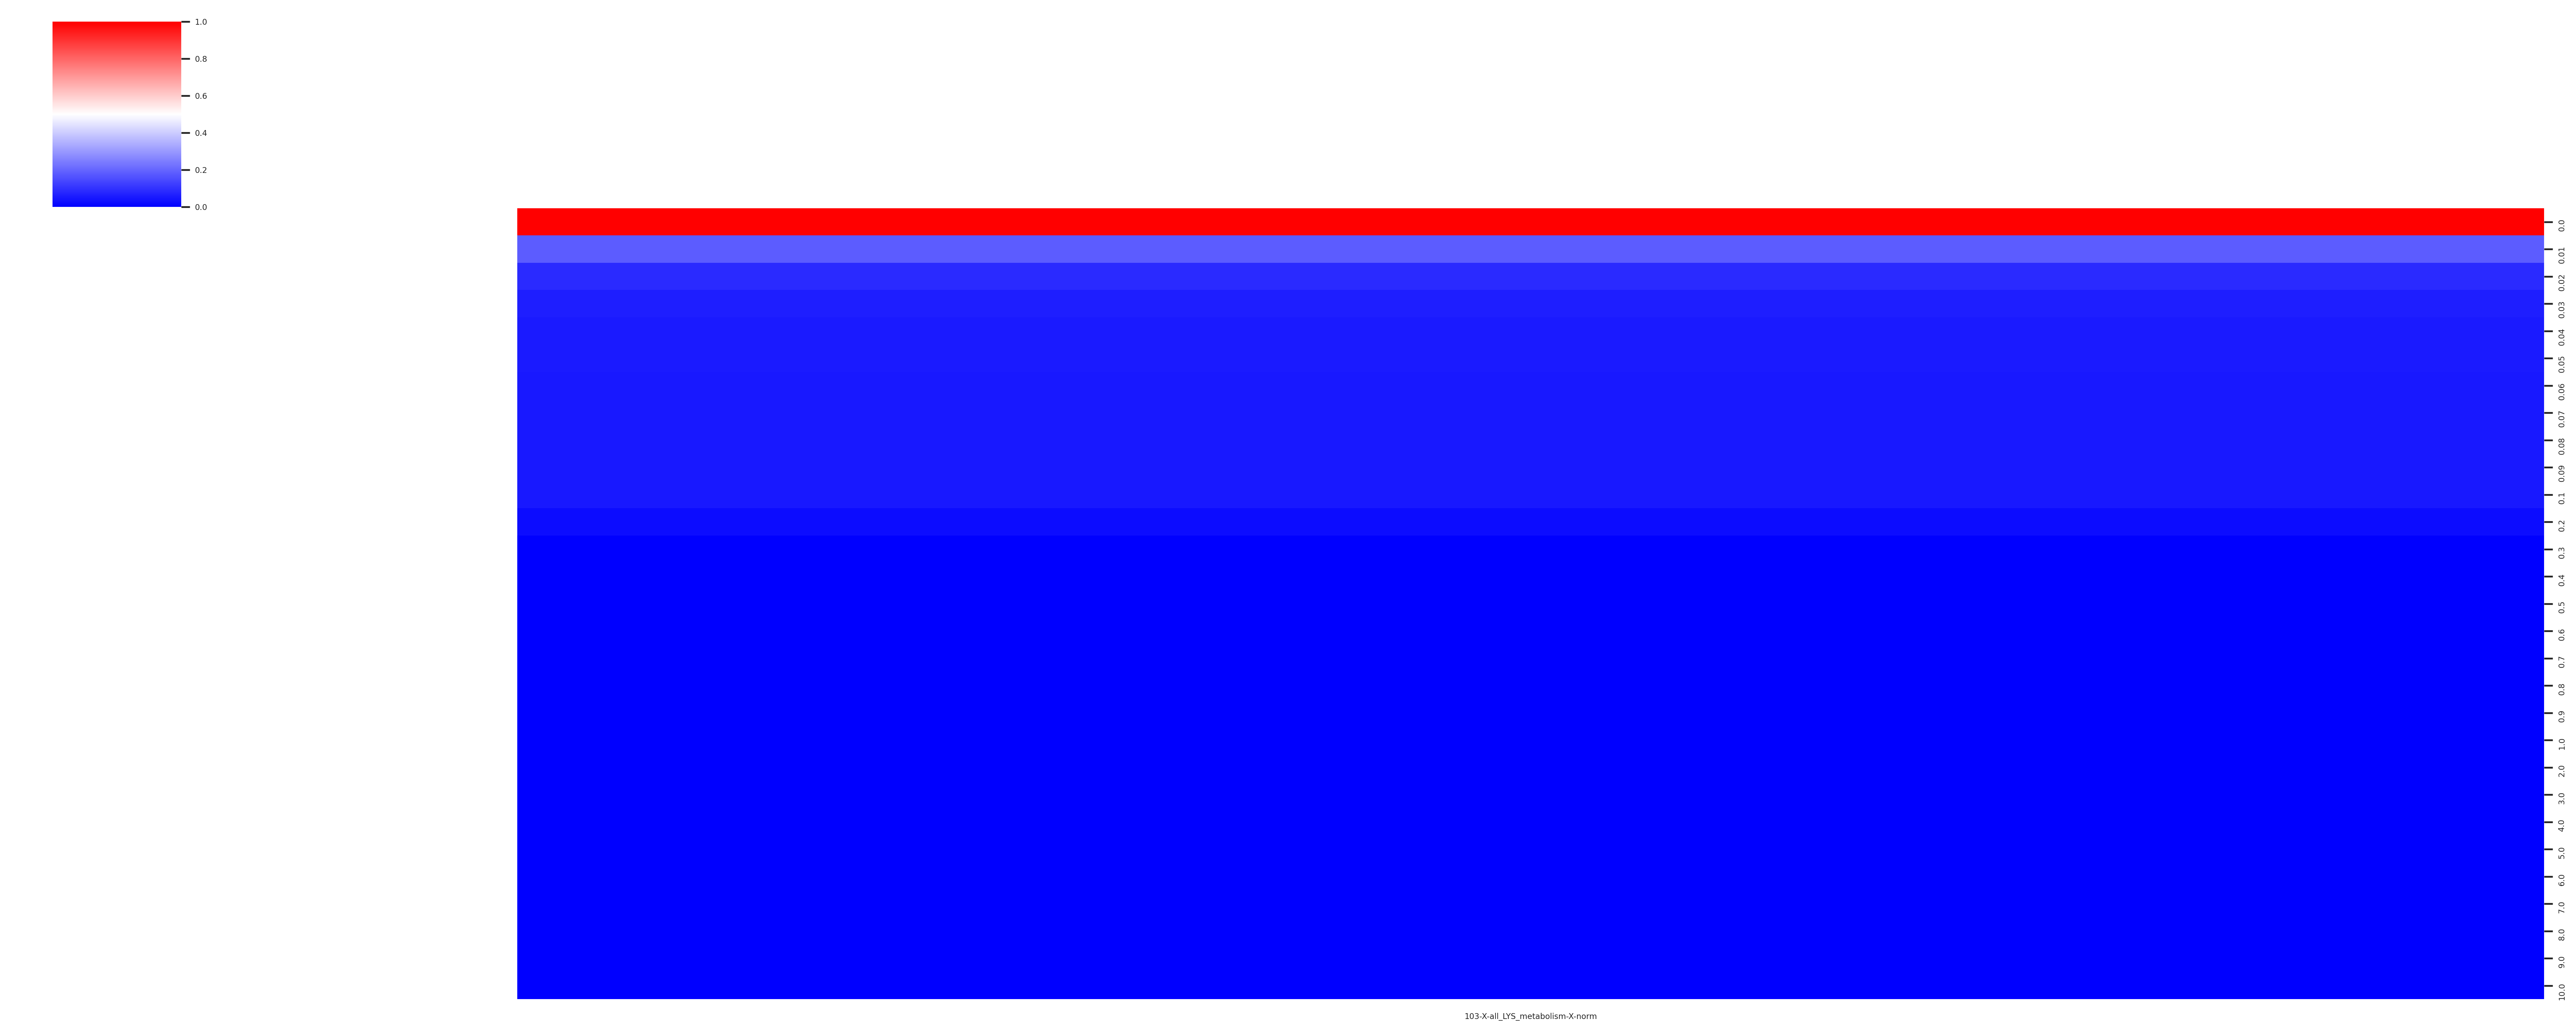

In [29]:
#plot pos fractions for different thresholds
sns.set(font_scale = 0.5) # if error matplotlib has no attribute DivergingNorm appears update Matplotlib
h = sns.clustermap(out_df,
               cmap='bwr', col_cluster=False, row_cluster=False, figsize=(25,10), vmax=1,center=0.5,vmin=0, z_score= None)


In [30]:
plotting_df_thresh_group.columns

Index(['103-X-all_LYS_metabolism-X-norm'], dtype='object')

In [31]:
#calculate means of pos_frac for every cell type
thresh = 0.01 #everything below will be considere nonexpression
group_obs = 'annotation_SPADE_1' #obs varaiable for grouping


plotting_df = adata.obs[metabolic_factors]
plotting_df_thresh = plotting_df.applymap(lambda x: np.nan if x < thresh else x)
plotting_df_thresh_group = plotting_df_thresh
plotting_df_thresh_group['groups'] = adata.obs[group_obs]
plotting_df_thresh_group['sample_id'] = adata.obs['sample_id']

series_list = []
series_columns = []

for i in set(plotting_df_thresh_group['groups']):
    df_subset = plotting_df_thresh_group[plotting_df_thresh_group['groups']==i]
    series_list.append(df_subset.groupby('sample_id').mean())#by default this ingnores nan --> only mean of pos. frac will be calculated
    series_columns.append(i)

In [32]:
#concatenate data from diff cell types into single df
df_program = pd.concat(series_list,axis=1)

df_program.columns = series_columns
df_program

,NK,CD8_T,mono,B_naive,B_memory,Treg,MDC,pDC,plasma,ILC3,mast,DC,gdT,B_GC,B_proliferating,T,CD4_T
sample_id,,,,,,,,,,,,,,,,,
P002_Post,0.014316,0.015440,NaN,0.016241,0.014634,0.015014,0.011232,0.011024,0.171792,0.010246,NaN,0.013341,NaN,0.013852,0.184282,0.017108,0.014959
P002_Pre,0.020660,0.018601,NaN,0.018644,0.020326,0.019568,0.017349,0.016932,0.176633,0.013792,0.020781,0.016479,NaN,0.019200,0.127183,0.014233,0.016900
P003_Post,0.017687,0.016682,NaN,0.023116,0.026533,0.014260,0.014867,0.023510,0.181442,0.013177,NaN,0.021431,NaN,NaN,NaN,0.016137,0.017137
P004_Pre,0.018629,0.014653,NaN,NaN,0.012611,0.014518,0.014942,0.038302,0.174095,NaN,0.018520,0.014062,NaN,NaN,NaN,0.014067,0.014736
P005_Post,0.017410,0.015377,NaN,0.020379,0.021235,0.014108,0.011868,0.029712,0.224953,0.016939,0.020463,0.016281,NaN,NaN,0.170982,0.013423,0.015569
P005_Pre,0.013122,0.013865,NaN,0.018429,0.014056,0.013244,NaN,0.012770,0.175529,NaN,NaN,0.010358,0.018183,NaN,NaN,NaN,0.014689
P007_Pre,0.017172,0.016067,NaN,0.015271,0.015165,0.015699,0.011444,0.020286,0.168214,0.010030,NaN,NaN,NaN,0.012936,0.095536,NaN,0.018265
P007_Prog,NaN,0.023354,NaN,NaN,NaN,NaN,0.014708,NaN,0.233069,NaN,NaN,0.015282,NaN,NaN,0.191762,NaN,0.015807
P012_Post,0.017808,0.016065,NaN,0.016874,0.015540,0.013471,0.013639,0.022224,0.173340,0.016643,NaN,NaN,NaN,0.015734,0.056540,NaN,0.015512


In [33]:
#prepare data for plotting with seaborn
df_program_trans = df_program.T
df_program_trans= df_program_trans.reset_index()
df_program_trans_melt = df_program_trans.melt(id_vars='index')
df_program_trans_melt['timepoint'] = df_program_trans_melt['sample_id'].str.slice(start=5)
#restrict to pre and post
df_program_trans_melt = df_program_trans_melt[df_program_trans_melt['timepoint'].isin(['Pre','Post'])]

saved figure to: /data/peer/wallet/Jupyter/SPADE_Peer_validation/figures/Zhang/TIL-X-BRCA-X-Zhang-X-2021-X-all_cells_raw_annotated_clustered_nodrops_nodoub_tumor_scran_labeled_clustered_annotated_211208_removed-doublets_naive0.01_delta_0.001_beta_0.0_pseudo_0.0_box-plot_celltypes.svg


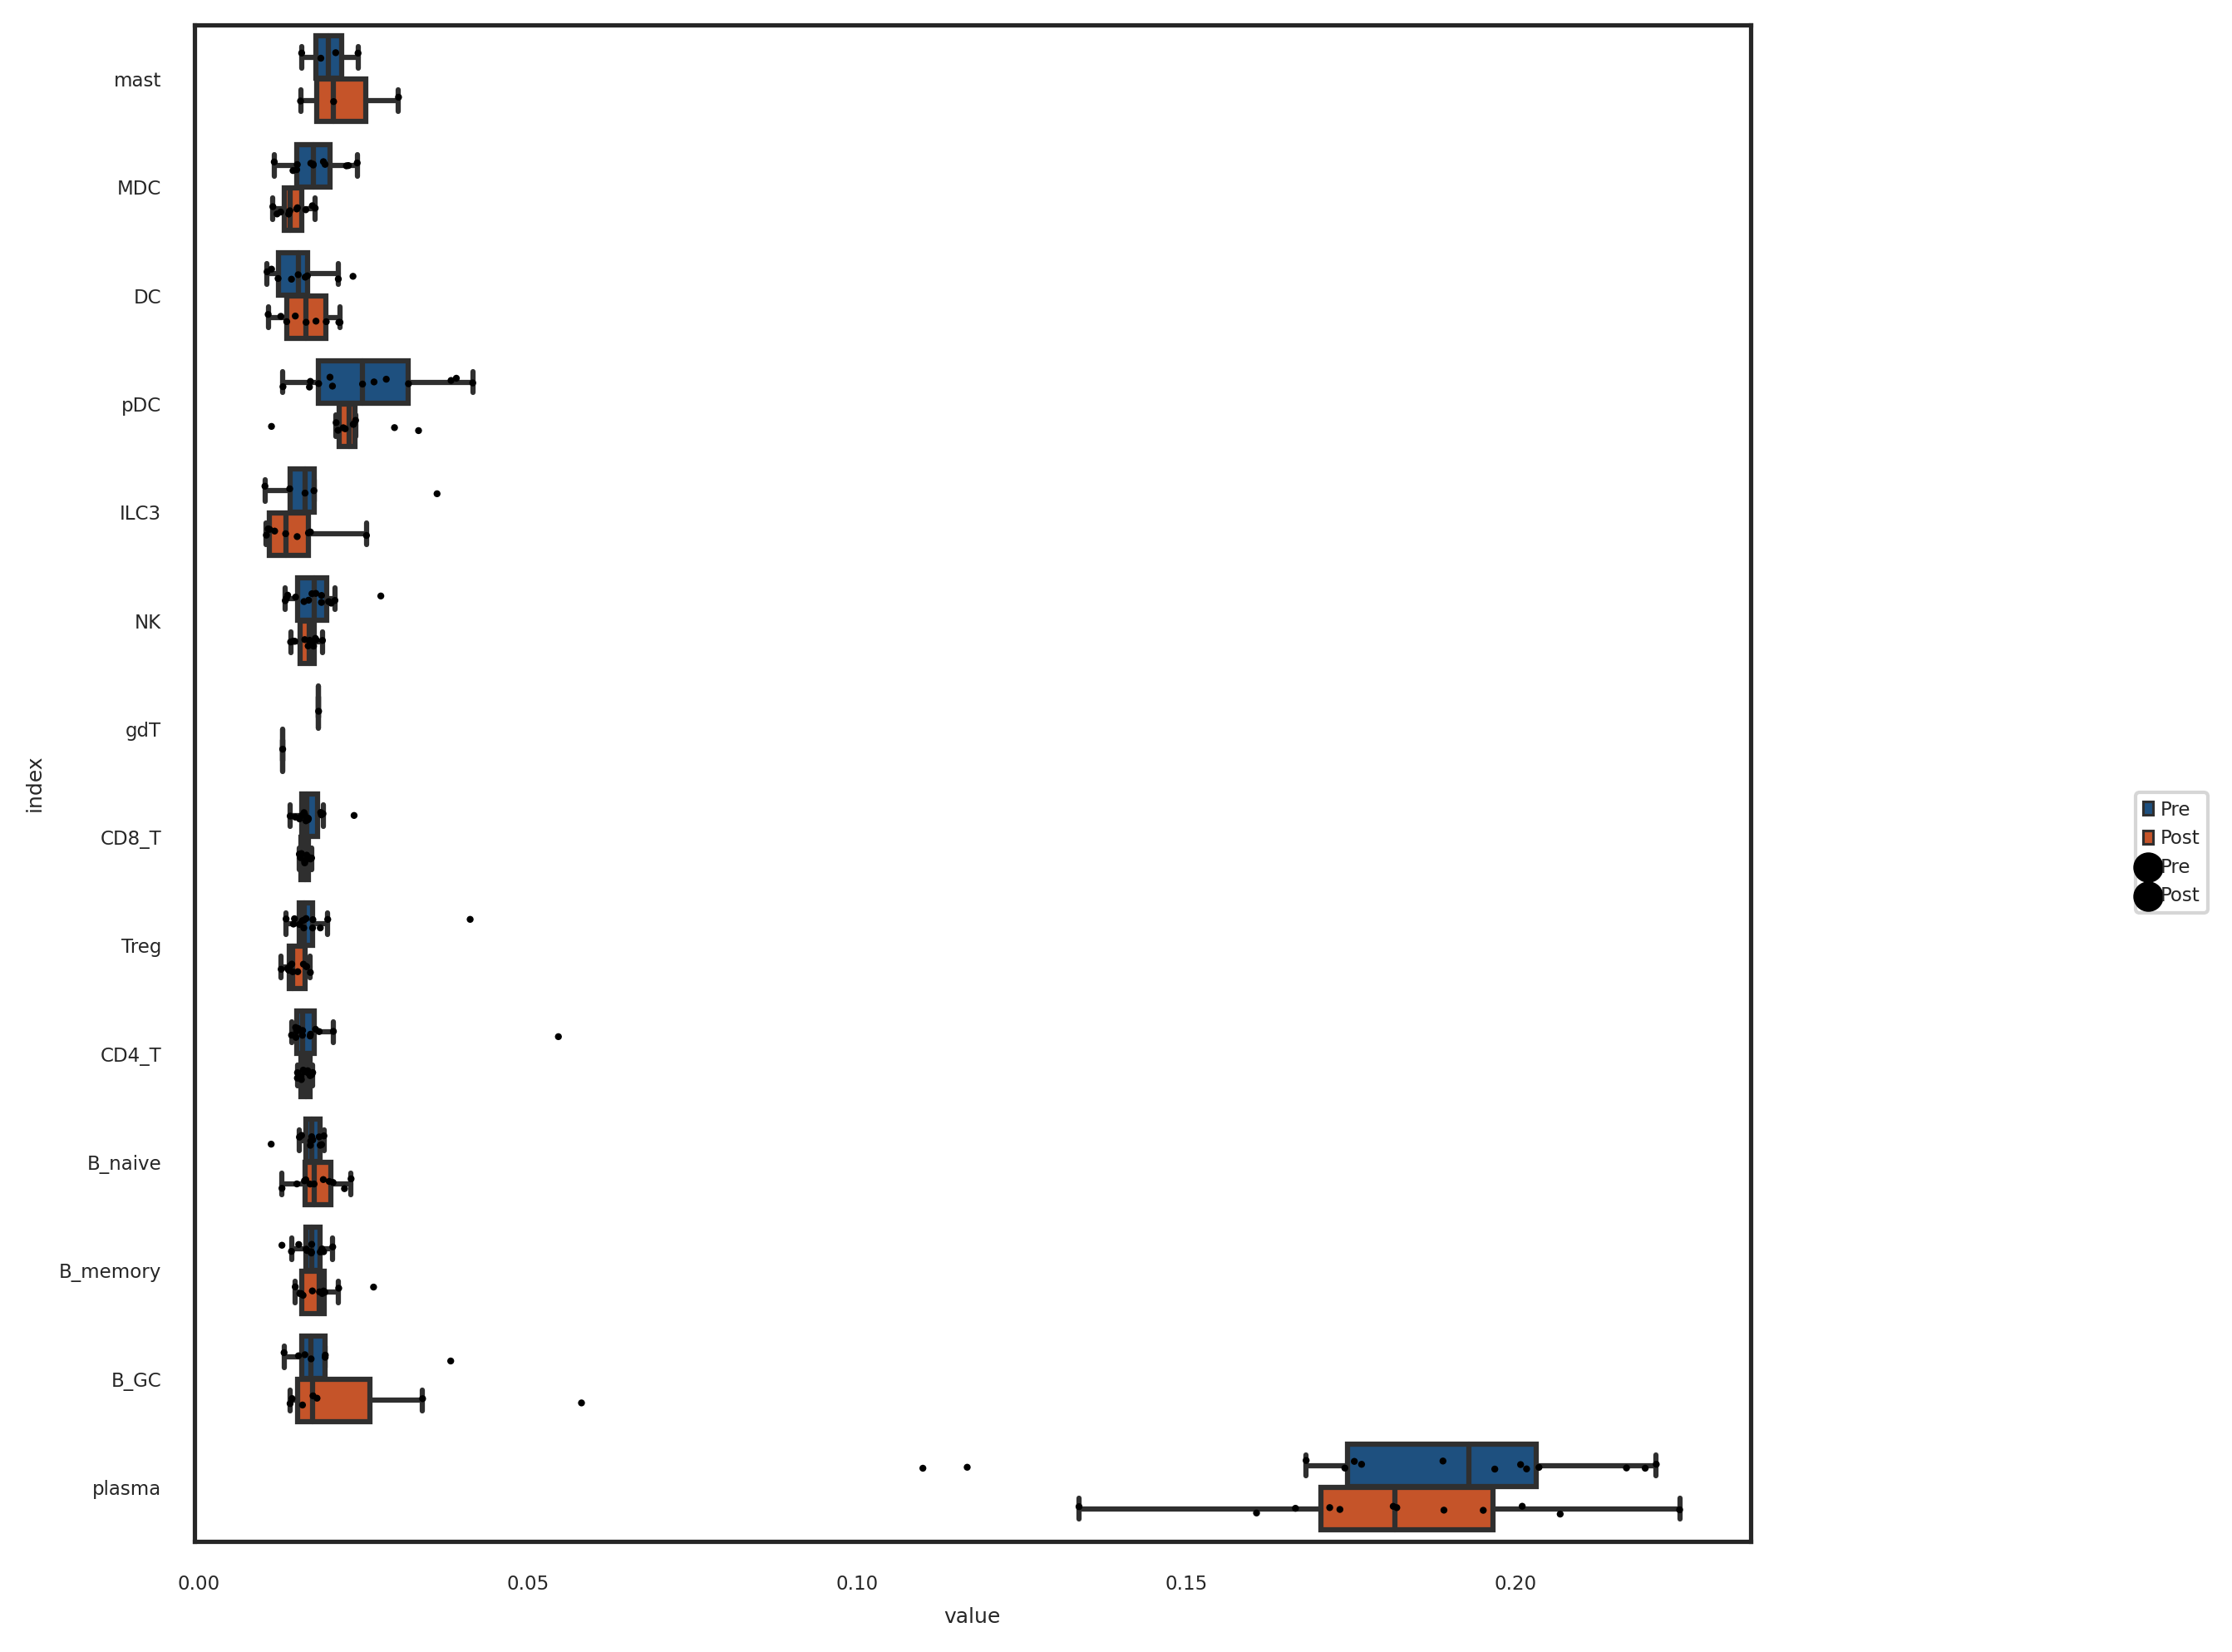

In [34]:
#plot with seaborn

sns.set_style('white')
order_list =[  'mast','MDC','DC','pDC', 'ILC3',
'NK', 'gdT', 'CD8_T','Treg', 'CD4_T',
 'B_naive','B_memory','B_GC',
 'plasma']
fig, ax = plt.subplots(figsize=(8,8))
sns.boxplot(x="value", y="index", hue= 'timepoint', data=df_program_trans_melt,hue_order=['Pre','Post'],
            palette=blue_red,fliersize=0, order =order_list  )
sns.stripplot(x="value",y="index",hue= 'timepoint', dodge=True, data=df_program_trans_melt,s=2,hue_order=['Pre','Post'],
             palette=['#000000']*len(set(df_program_trans_melt['index'])),order =order_list  )
plt.legend(bbox_to_anchor=(0.8, 0., 0.5, 0.5))
save_path_figure_complete = fig_save_path+adata_path_adata[:-5]+'_'+'box-plot_celltypes.svg'
plt.savefig(save_path_figure_complete,dpi=300)
print('saved figure to:',save_path_figure_complete)

In [35]:
adata

AnnData object with n_obs × n_vars = 150985 × 20237
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'patient_id', 'biomaterial', 'timepoint', 'site', 'age', 'PD-L1_IC_Ventana', 'TIL', 'T', 'N', 'M', 'treatment', 'RECIST', 'biopsied_lesion_size', '8w_biopsied_lesion', 'target_lesion_size', '8w_target_lesion', 'PFS', 'last_follow_up', 'pheno_k10', 'pheno_k20', 'pheno_k30', 'pheno_k40', 'pheno_k50', 'pheno_k60', 'pheno_k70', 'pheno_k80', 'pheno_k90', 'pheno_k100', 'annotation_SPADE_1', 'annotation_SPADE_2', '0-X-all_multidrug-resistance', '1-X-all_porphyrine-heme_metabolism', '2-X-all_TNF-via-NFkB_signaling', '3-X-all_glyoxylate-dicarboxylate_metabolism', '4-X-all_IL6-JAK-STAT3_signaling', '5-X-all_fatty-acid-beta-oxidation-peroxisomal', '6-X-all_triacylglycerol_synthesis', '7-X-all_circadian-rhythm', '8-X-8', '9-X-all_au

saved figure to: /data/peer/wallet/Jupyter/SPADE_Peer_validation/figures/Zhang/TIL-X-BRCA-X-Zhang-X-2021-X-all_cells_raw_annotated_clustered_nodrops_nodoub_tumor_scran_labeled_clustered_annotated_211208_removed-doublets_naive0.01_delta_0.001_beta_0.0_pseudo_0.0_histplot_celltypes_LYS.svg


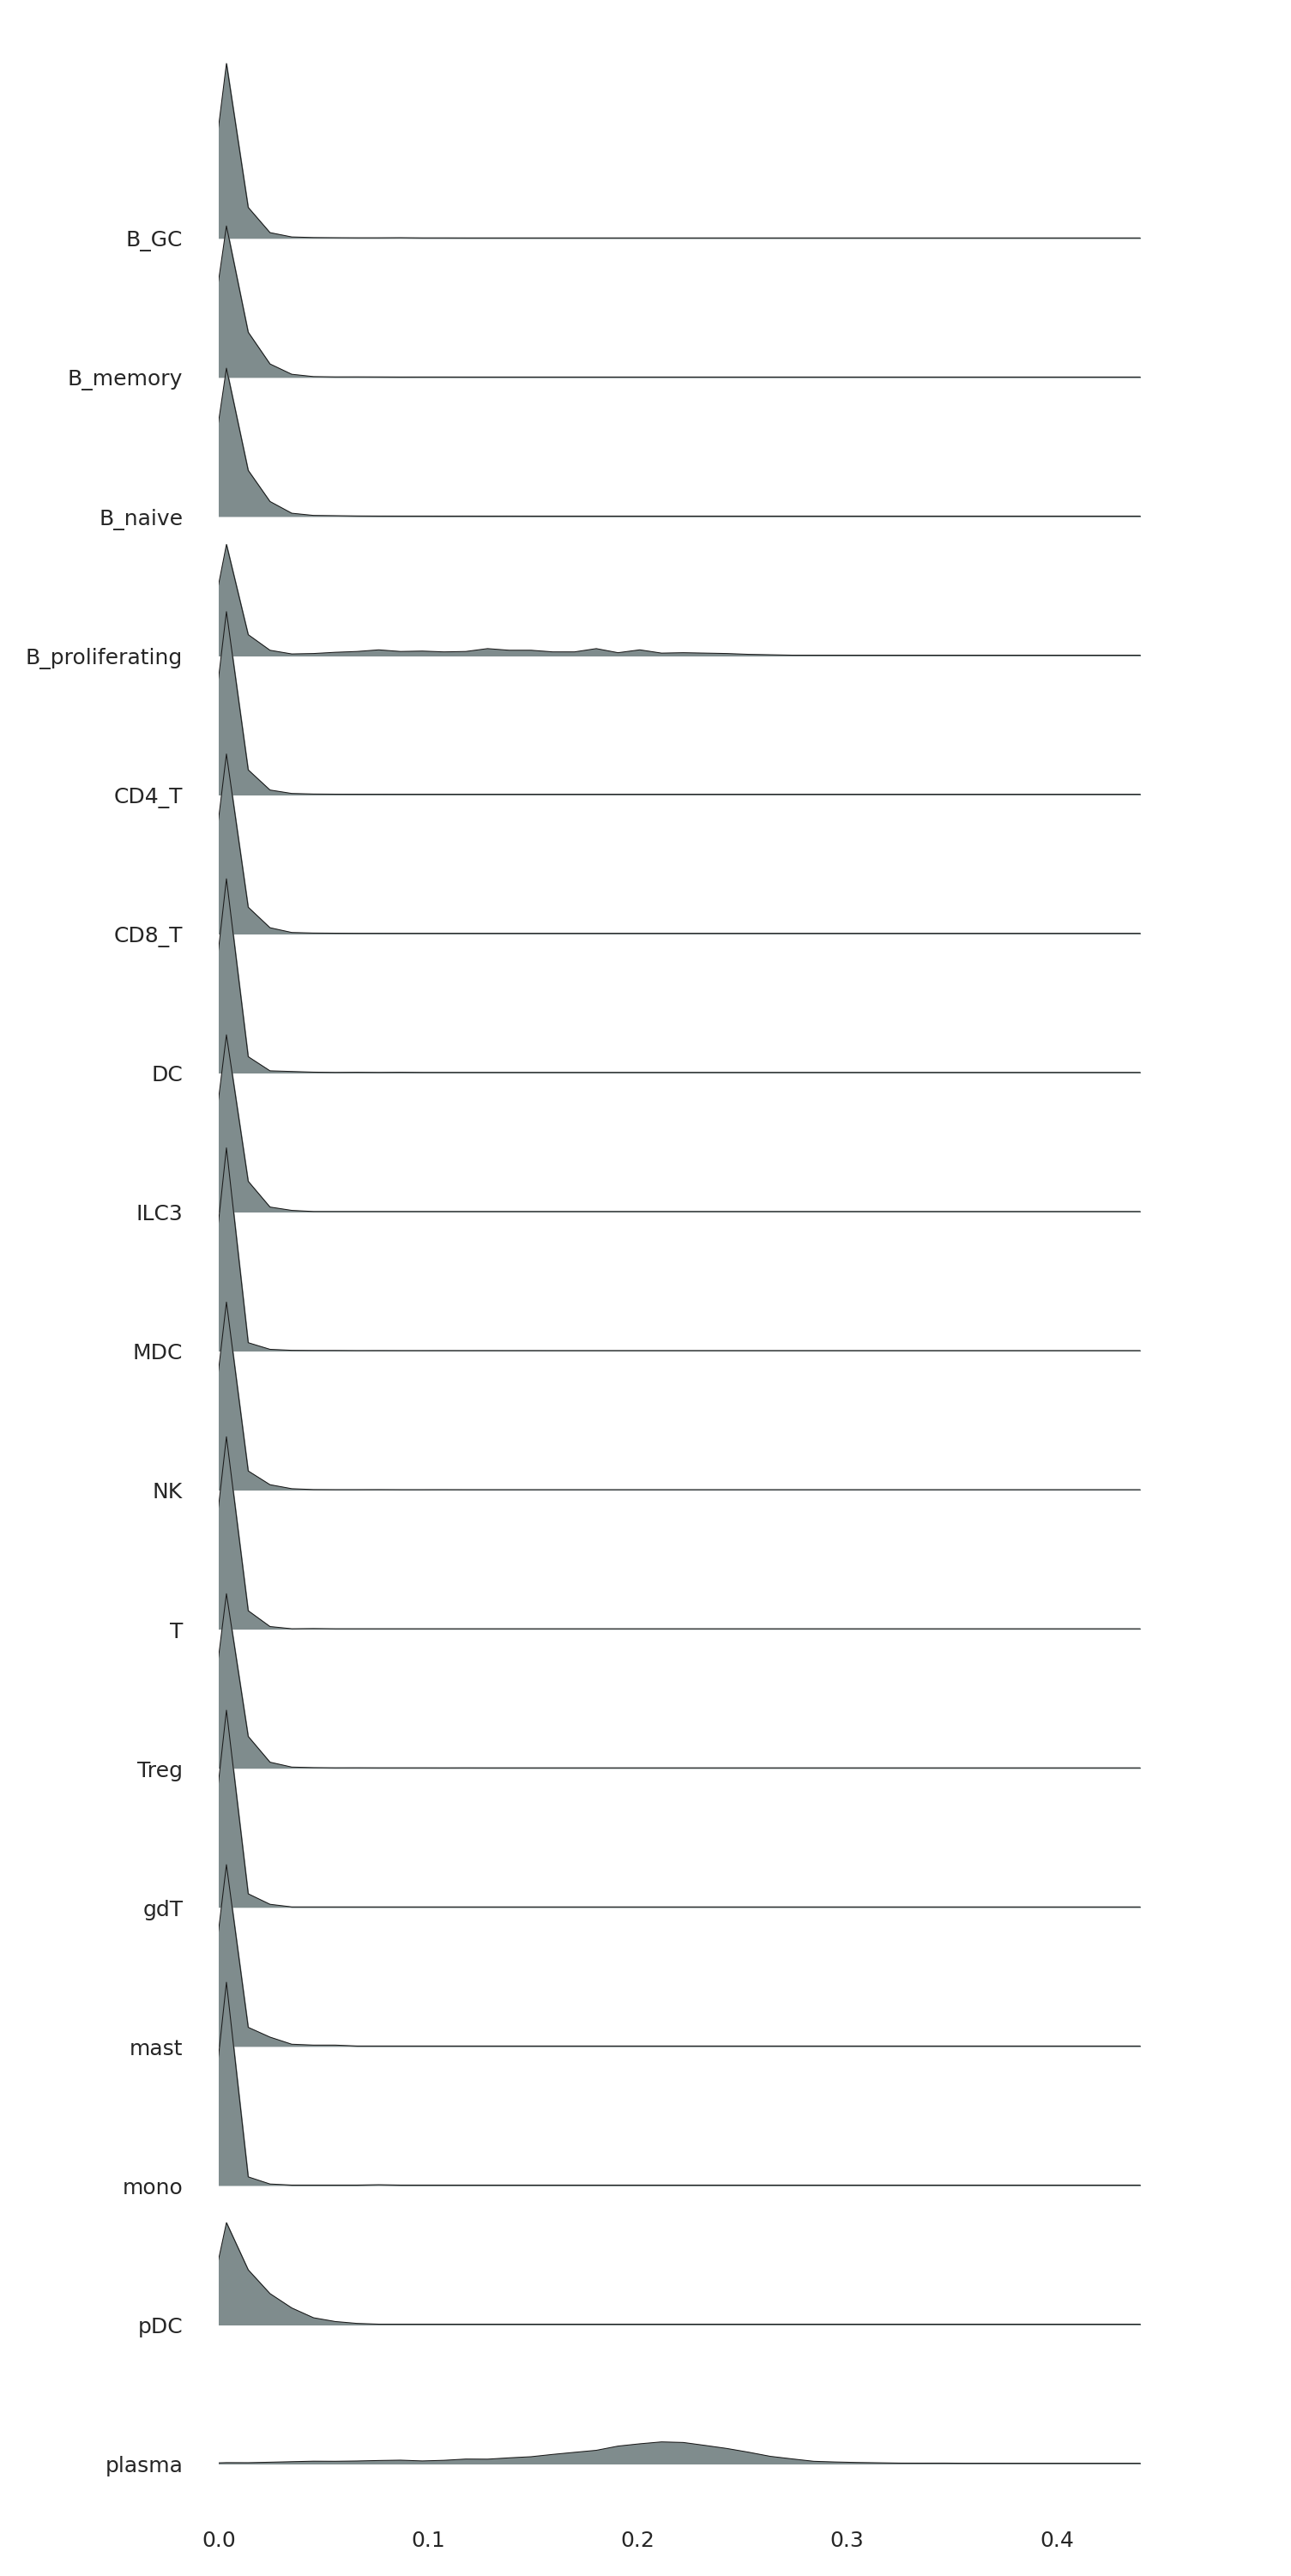

In [36]:
import joypy

sns.set_style('white')
plot_df = adata.obs[['annotation_SPADE_1',metabolic_factors[0]]]
fig, axes = joypy.joyplot(plot_df, by="annotation_SPADE_1",kind='normalized_counts',bins=50,linewidth=0.25,figsize=(5,10),
                         color='#7F8C8D')
for i in axes:
    i.set_xlim(0,.5)
save_path_figure_complete = fig_save_path+adata_path_adata[:-5]+'_'+'histplot_celltypes_LYS.svg'
plt.savefig(save_path_figure_complete,dpi=300)
print('saved figure to:',save_path_figure_complete)

In [37]:
input_gene_sets = DATA_DIR + 'SPADE_genes_x_genesets.csv'
input_df = pd.read_csv(input_gene_sets)
input_df


,gs.name,g.name
0,all_multidrug-resistance,ABCC4
1,all_multidrug-resistance,ABCB4
2,all_multidrug-resistance,ABCC3
3,all_multidrug-resistance,ABCC1
4,all_porphyrine-heme_metabolism,UROS
...,...,...
7855,all_folate_metabolism,SLC19A1
7856,all_folate_metabolism,AMT
7857,all_folate_metabolism,FOLR3
7858,all_folate_metabolism,FTCD


In [38]:
Bassez_genes = set(['BBOX1',
 'AASS',
 'SPCS2',
 'ALDH7A1',
 'TMLHE',
 'SLC7A1',
 'SPCS3',
 'SLC6A8',
 'SLC25A15',
 'PLPBP',
 'AADAT',
 'SPCS1',
 'PIPOX',
 'PYCR3',
 'SLC6A7',
 'PYCR2',
 'SLC7A2',
 'SLC3A1',
 'XBP1',
 'SEC11C',
 'SDF2L1',
 'HSP90B1',
 'HSPA5',
 'TPT1',
 'MYDGF',
 'PDIA6',
 'TMEM59',
 'SELENOS',
 'OSTC',
 'SSR3',
 'SEC61B',
 'SSR4',
 'SEC61G',
 'CANX',
 'PLPP5',
 'FKBP11',
 'DNAJB9',
 'HERPUD1',
 'TMED2',
 'NUCB2',
 'TRAM1',
 'SSR1',
 'ERLEC1',
 'SEC61A1',
 'FKBP2',
 'SERP1',
 'IGKC',
 'ITM2C',
 'ALDH2',
 'MTDH'])

In [39]:
input_set = set(input_df[input_df['gs.name']=='all_LYS_metabolism']['g.name'])

In [40]:
Zhang_set = set(adata.uns['SPADE_markers_global']['103-X-all_LYS_metabolism'])

In [41]:
list(adata.uns['SPADE_markers_global']['103-X-all_LYS_metabolism'])

['BBOX1',
 'ALDH7A1',
 'AASS',
 'TMLHE',
 'SPCS3',
 'AADAT',
 'PIPOX',
 'SLC7A1',
 'SPCS1',
 'SLC7A2',
 'SLC7A3',
 'SLC3A1',
 'PRDX4',
 'TENT5C',
 'DERL3',
 'DUSP5',
 'MZB1',
 'JCHAIN',
 'IGKC',
 'FTL',
 'XBP1',
 'IGLL5',
 'SSR4',
 'IFI6',
 'SDF2L1',
 'SEC11C',
 'HERPUD1',
 'FKBP2',
 'CD79A',
 'TMEM59',
 'ITM2C',
 'SSR3',
 'ISG20',
 'MIF',
 'CYBA',
 'SEC61B',
 'CD74',
 'FTH1',
 'HLA-C',
 'TMED2',
 'SVIP',
 'NME2',
 'PDIA6',
 'SERP1',
 'MYDGF',
 'GSTP1',
 'GAPDH',
 'ERLEC1',
 'DAD1',
 'TPT1']

saved Figure to: /data/peer/wallet/Jupyter/SPADE_Peer_validation/figures/Zhang/TIL-X-BRCA-X-Zhang-X-2021-X-all_cells_raw_annotated_clustered_nodrops_nodoub_tumor_scran_labeled_clustered_annotated_211208_removed-doublets_naive0.01_delta_0.001_beta_0.0_pseudo_0.0_venn-Zhang-et-al_lambda0.1LYSmeta.svg


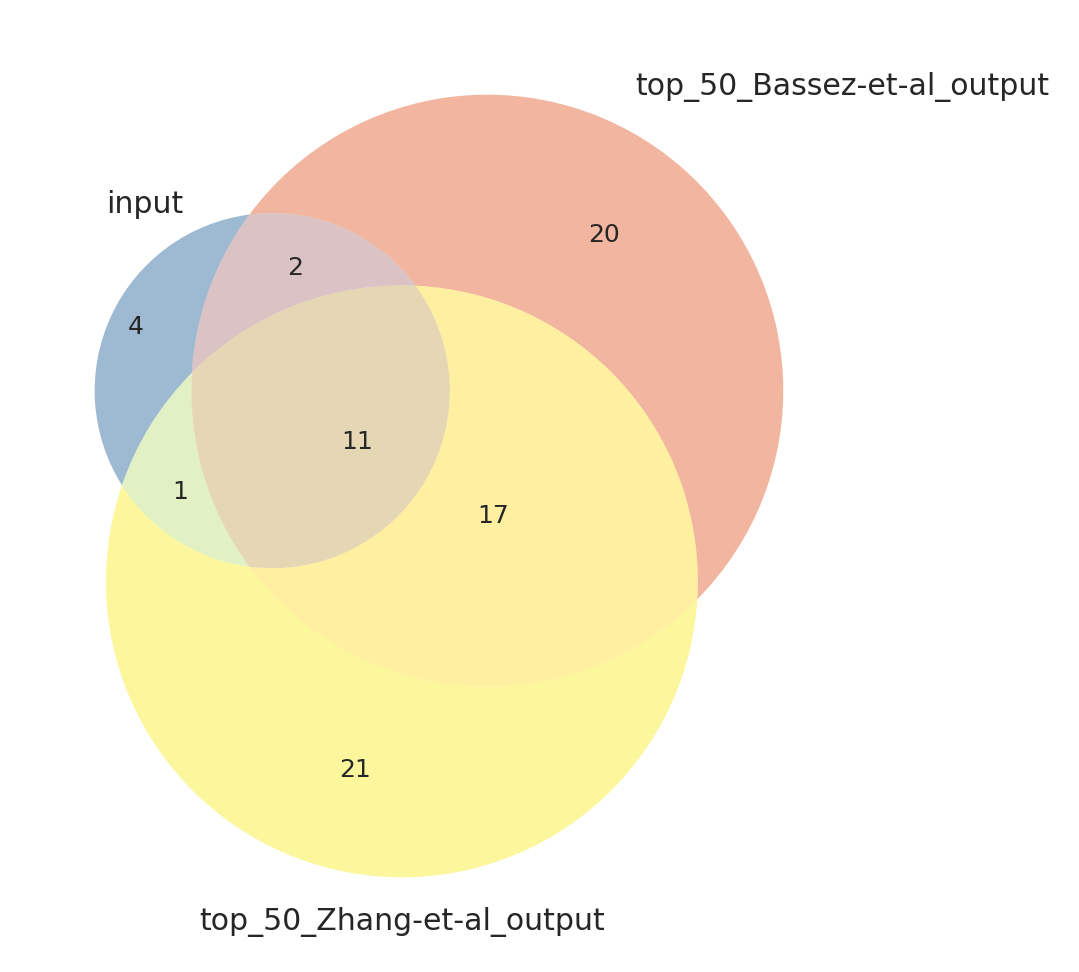

In [42]:
#venn for input output and Zhang data lambda 0.1

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt

output_genes =set(['BBOX1', 'AASS', 'SPCS2', 'ALDH7A1', 'TMLHE', 'SLC7A1', 'SPCS3',
       'SLC6A8', 'SLC25A15', 'PLPBP', 'AADAT', 'SPCS1', 'PIPOX', 'PYCR3',
       'SLC6A7', 'PYCR2', 'SLC7A2', 'SLC3A1', 'XBP1', 'SEC11C', 'SDF2L1',
       'HSP90B1', 'HSPA5', 'TPT1', 'MYDGF', 'PDIA6', 'TMEM59', 'SELENOS',
       'OSTC', 'SSR3', 'SEC61B', 'SSR4', 'SEC61G', 'CANX', 'PLPP5',
       'FKBP11', 'DNAJB9', 'HERPUD1', 'TMED2', 'NUCB2', 'TRAM1', 'SSR1',
       'ERLEC1', 'SEC61A1', 'FKBP2', 'SERP1', 'IGKC', 'ITM2C', 'ALDH2',
       'MTDH'])

Zhang_et_al = set(adata.uns['SPADE_markers_global']['103-X-all_LYS_metabolism'])
input_genes = set(input_df[input_df['gs.name']=='all_LYS_metabolism']['g.name'])

#get intersections and set differerences 
a = len((input_genes-output_genes)-Zhang_et_al)
b = len((output_genes-input_genes)-Zhang_et_al)
c = len((output_genes.intersection(input_genes))-Zhang_et_al)
d = len((Zhang_et_al-output_genes)-input_genes)
e = len((Zhang_et_al.intersection(input_genes))-output_genes)
f = len((Zhang_et_al.intersection(output_genes))-input_genes)
g = len(Zhang_et_al.intersection(output_genes).intersection(input_genes))

venn3(subsets=(a,b,c,d,e,f,g),set_labels=('input','top_50_Bassez-et-al_output','top_50_Zhang-et-al_output'),
     set_colors= blue_red+['#F9EB0C'])
save_fig_path = fig_save_path+adata_path_adata[:-5]+'_venn-Zhang-et-al_lambda0.1'+'LYSmeta'+'.svg'
plt.savefig(save_fig_path,dpi=300)
print('saved Figure to:',save_fig_path)

In [43]:
(Zhang_et_al.intersection(output_genes))-input_genes

{'ERLEC1',
 'FKBP2',
 'HERPUD1',
 'IGKC',
 'ITM2C',
 'MYDGF',
 'PDIA6',
 'SDF2L1',
 'SEC11C',
 'SEC61B',
 'SERP1',
 'SSR3',
 'SSR4',
 'TMED2',
 'TMEM59',
 'TPT1',
 'XBP1'}

In [44]:
Zhang_et_al.intersection(output_genes).intersection(input_genes)

{'AADAT',
 'AASS',
 'ALDH7A1',
 'BBOX1',
 'PIPOX',
 'SLC3A1',
 'SLC7A1',
 'SLC7A2',
 'SPCS1',
 'SPCS3',
 'TMLHE'}

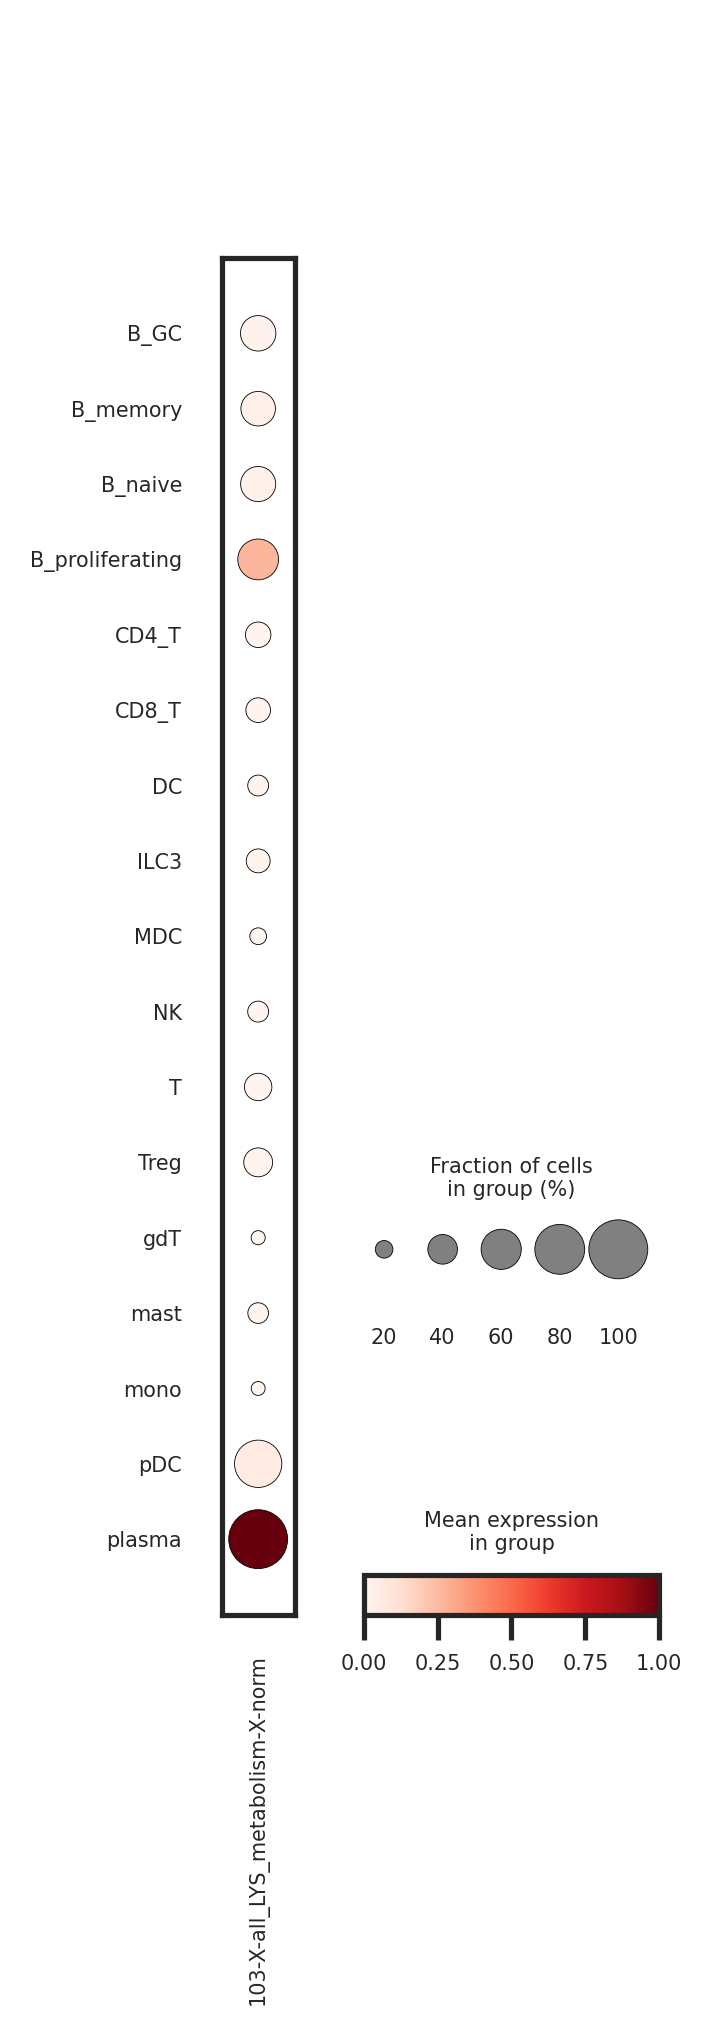

In [45]:
sns.set_style('white')
sc.pl.dotplot(adata, ['103-X-all_LYS_metabolism-X-norm'], 'annotation_SPADE_1',
              standard_scale='var',return_fig=False,expression_cutoff=0.001,save='Zhang_0.01_Lys_perceltype.svg')


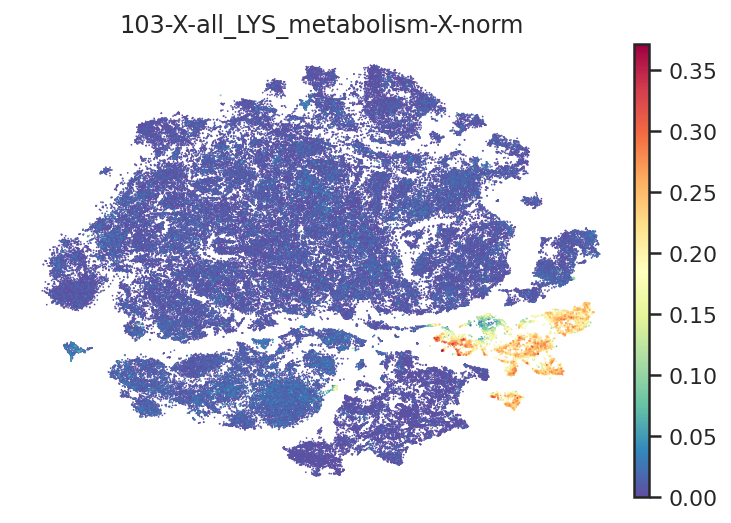

In [50]:
sc.pl.tsne(adata, color = '103-X-all_LYS_metabolism-X-norm', s = 3, cmap='Spectral_r', legend_fontsize = 10, vmin=0,save='Zhang-0.01_LYS.svg')